<h1>AI-Modell för KokoBananas</h1>

---

<h3>Import</h3>

In [598]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler

from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score

import warnings 
warnings.filterwarnings('ignore')

---

<h3>EDA</h3>

In [540]:
df = pd.read_csv("../data/project_data.csv")
print(df.info())
print(df.isnull().sum())
print(df.describe())
print(df.columns)
df = df.drop(columns="Unnamed: 0", axis=1) # Verkar vara en gammal index kolumn

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               12330 non-null  int64  
 1   Administrative           12330 non-null  int64  
 2   Administrative_Duration  12330 non-null  float64
 3   Informational            12330 non-null  int64  
 4   Informational_Duration   12330 non-null  float64
 5   ProductRelated           12330 non-null  int64  
 6   ProductRelated_Duration  12330 non-null  float64
 7   BounceRates              12330 non-null  float64
 8   ExitRates                12330 non-null  float64
 9   PageValues               12330 non-null  float64
 10  SpecialDay               12207 non-null  float64
 11  Month                    12330 non-null  object 
 12  OperatingSystems         12330 non-null  int64  
 13  Browser                  12146 non-null  float64
 14  Region                

In [541]:
print(f"shape: {df.shape}")
rows_with_nulls = df.isnull().any(axis=1).sum()
print("Row count with null:", rows_with_nulls)
df.head(10)

shape: (12330, 18)
Row count with null: 687


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,NaN,1.0,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.0,0.0,Feb,2,2.0,NaN,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Feb,4,1.0,NaN,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.0,0.0,Feb,3,2.0,2.0,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.0,0.0,Feb,3,3.0,1.0,4,Returning_Visitor,True,False
5,0,0.0,0,0.0,19,154.216667,0.015789,0.024561,0.0,0.0,Feb,2,2.0,1.0,3,Returning_Visitor,False,False
6,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.4,Feb,2,4.0,3.0,3,Returning_Visitor,False,False
7,1,0.0,0,0.0,0,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,2.0,1.0,5,Returning_Visitor,True,False
8,0,0.0,0,0.0,2,37.000000,0.000000,0.100000,0.0,0.8,Feb,2,2.0,2.0,3,Returning_Visitor,False,False
9,0,0.0,0,0.0,3,738.000000,0.000000,0.022222,0.0,0.4,Feb,2,4.0,1.0,2,Returning_Visitor,False,False


In [542]:
unique_values = [df[col].unique() for col in df.columns]
for col, unique_val in zip(df.columns, unique_values):
    print(f"Unique values in column {col}: {unique_val}")


Unique values in column Administrative: [  0   1   2   4  12   3  10   6  -3  -8  -1   5   9  -7 -10   8  16  13
  11   7  -9  18  14  -5  17  19  15  -2  24  -6  -4  22  21  20  23  27
  26]
Unique values in column Administrative_Duration: [  0.         53.         64.6       ... 167.9107143 305.125
 150.3571429]
Unique values in column Informational: [ 0  1  2  4 16  5  3 14  6 12  7  9 10  8 11 24 13]
Unique values in column Informational_Duration: [  0.   120.    16.   ... 547.75 368.25 211.25]
Unique values in column ProductRelated: [  1   2  10  19   0   3  16   7   6  23  13  20   8   5  32   4  45  14
  52   9  46  15  22  11  12  36  42  27  90  18  38  17 128  25  30  21
  51  26  28  31  24  50  96  49  68  98  67  55  35  37  29  34  71  63
  87  40  33  54  64  75  39 111  81  61  47  44  88 149  41  79  66  43
 258  80  62  83 173  48  58  57  56  69  82  59 109 287  53  84  78 137
 113  89  65  60 104 129  77  74  93  76  72 194 140 110 132 115  73 328
 160  86 150  95 1

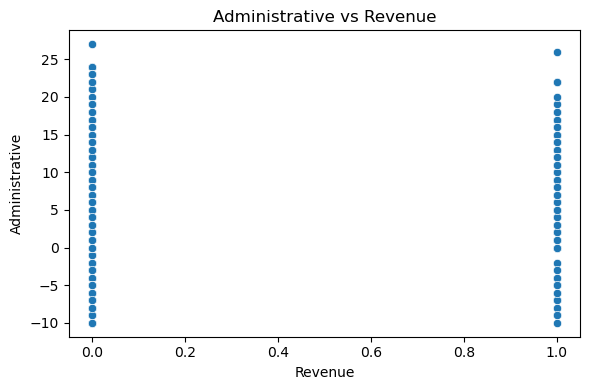

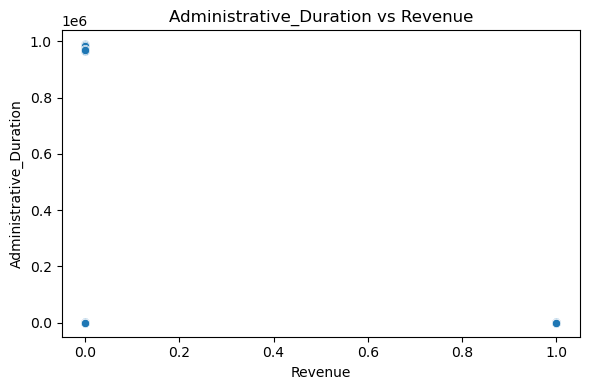

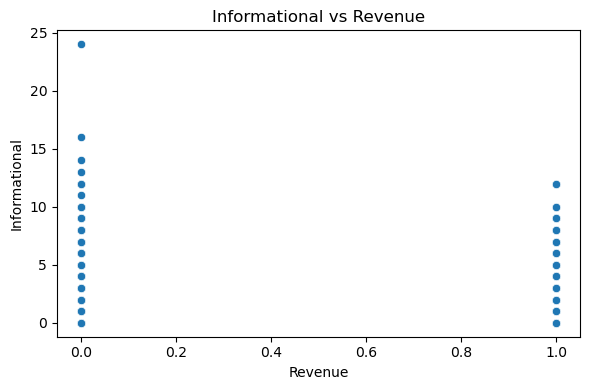

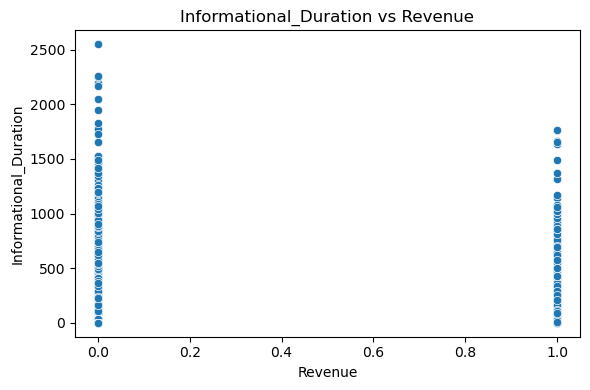

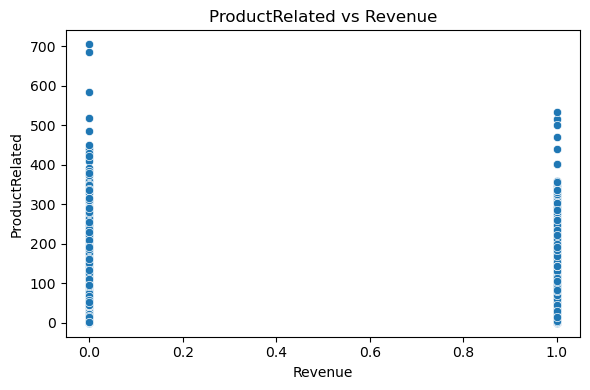

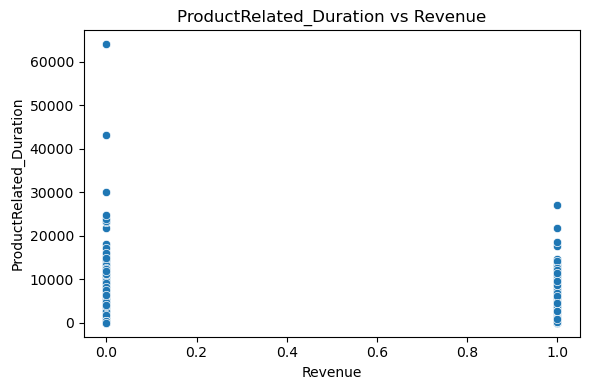

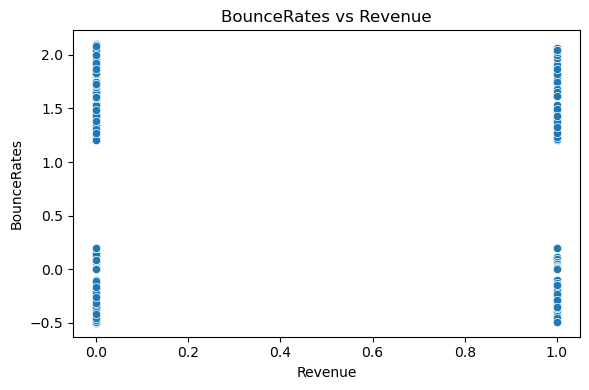

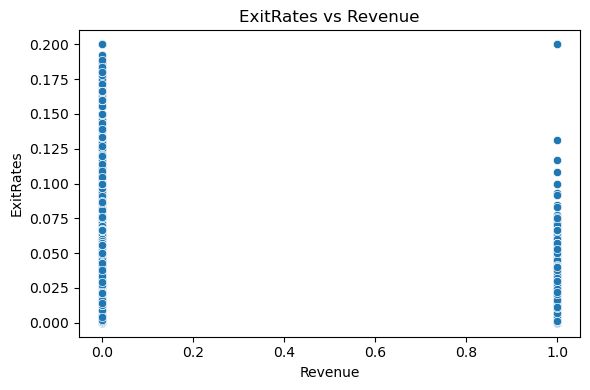

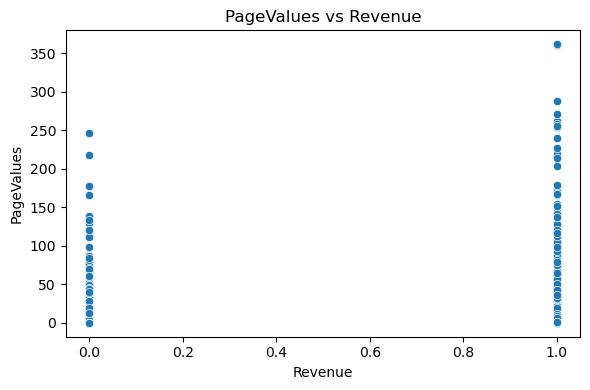

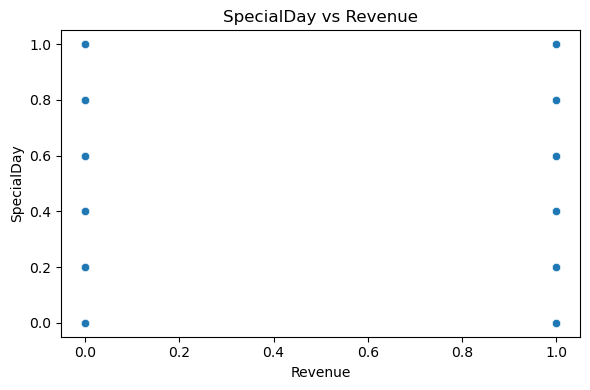

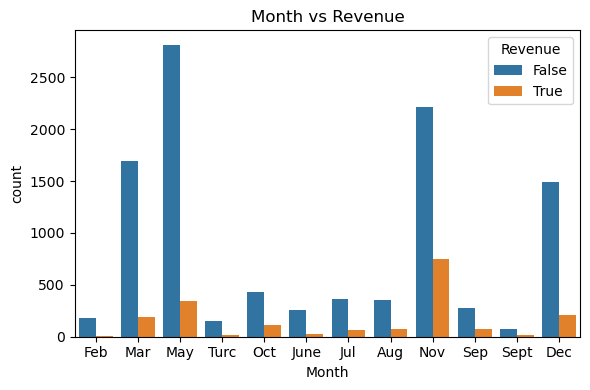

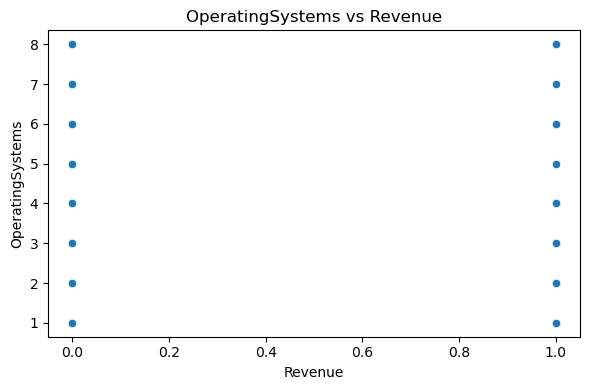

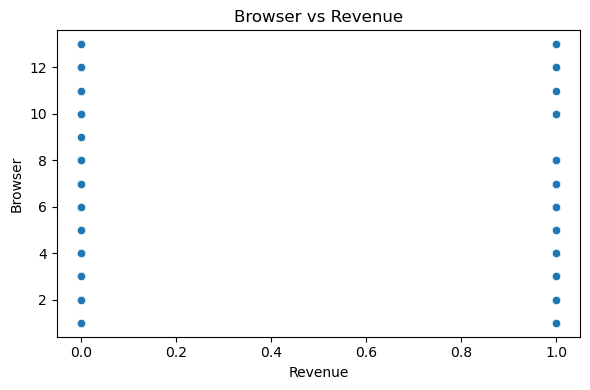

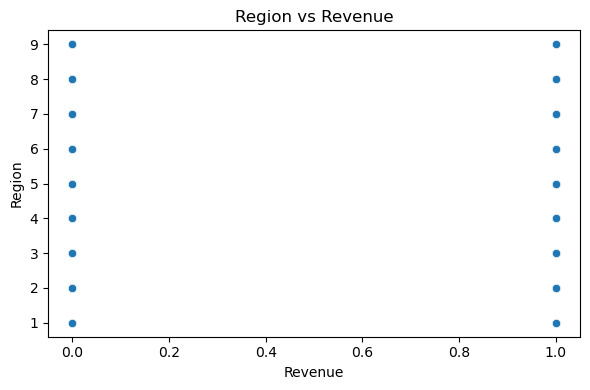

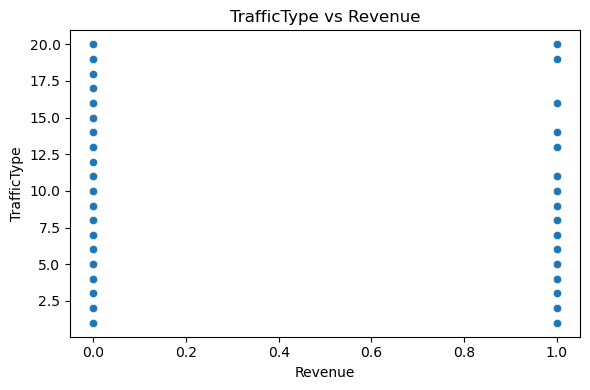

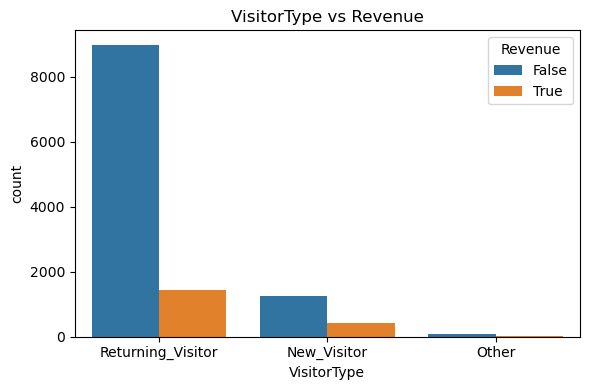

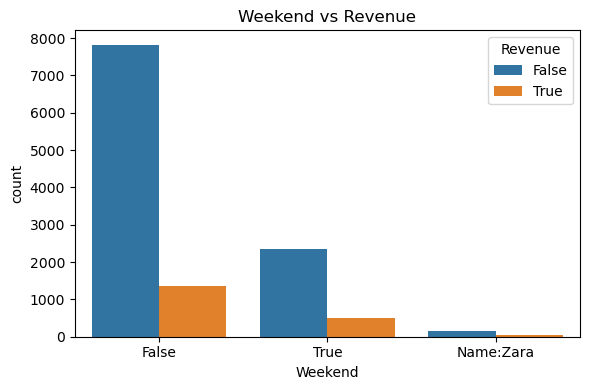

In [543]:
target_col = "Revenue"

for col in df.columns:
    if col != target_col:
        plt.figure(figsize=(6, 4))

        if pd.api.types.is_numeric_dtype(df[col]):
            sns.scatterplot(x=target_col, y=col, data=df)
        else:
            sns.countplot(x=col, hue=target_col, data=df)
        
        plt.title(f"{col} vs {target_col}")
        plt.tight_layout()
        plt.show()


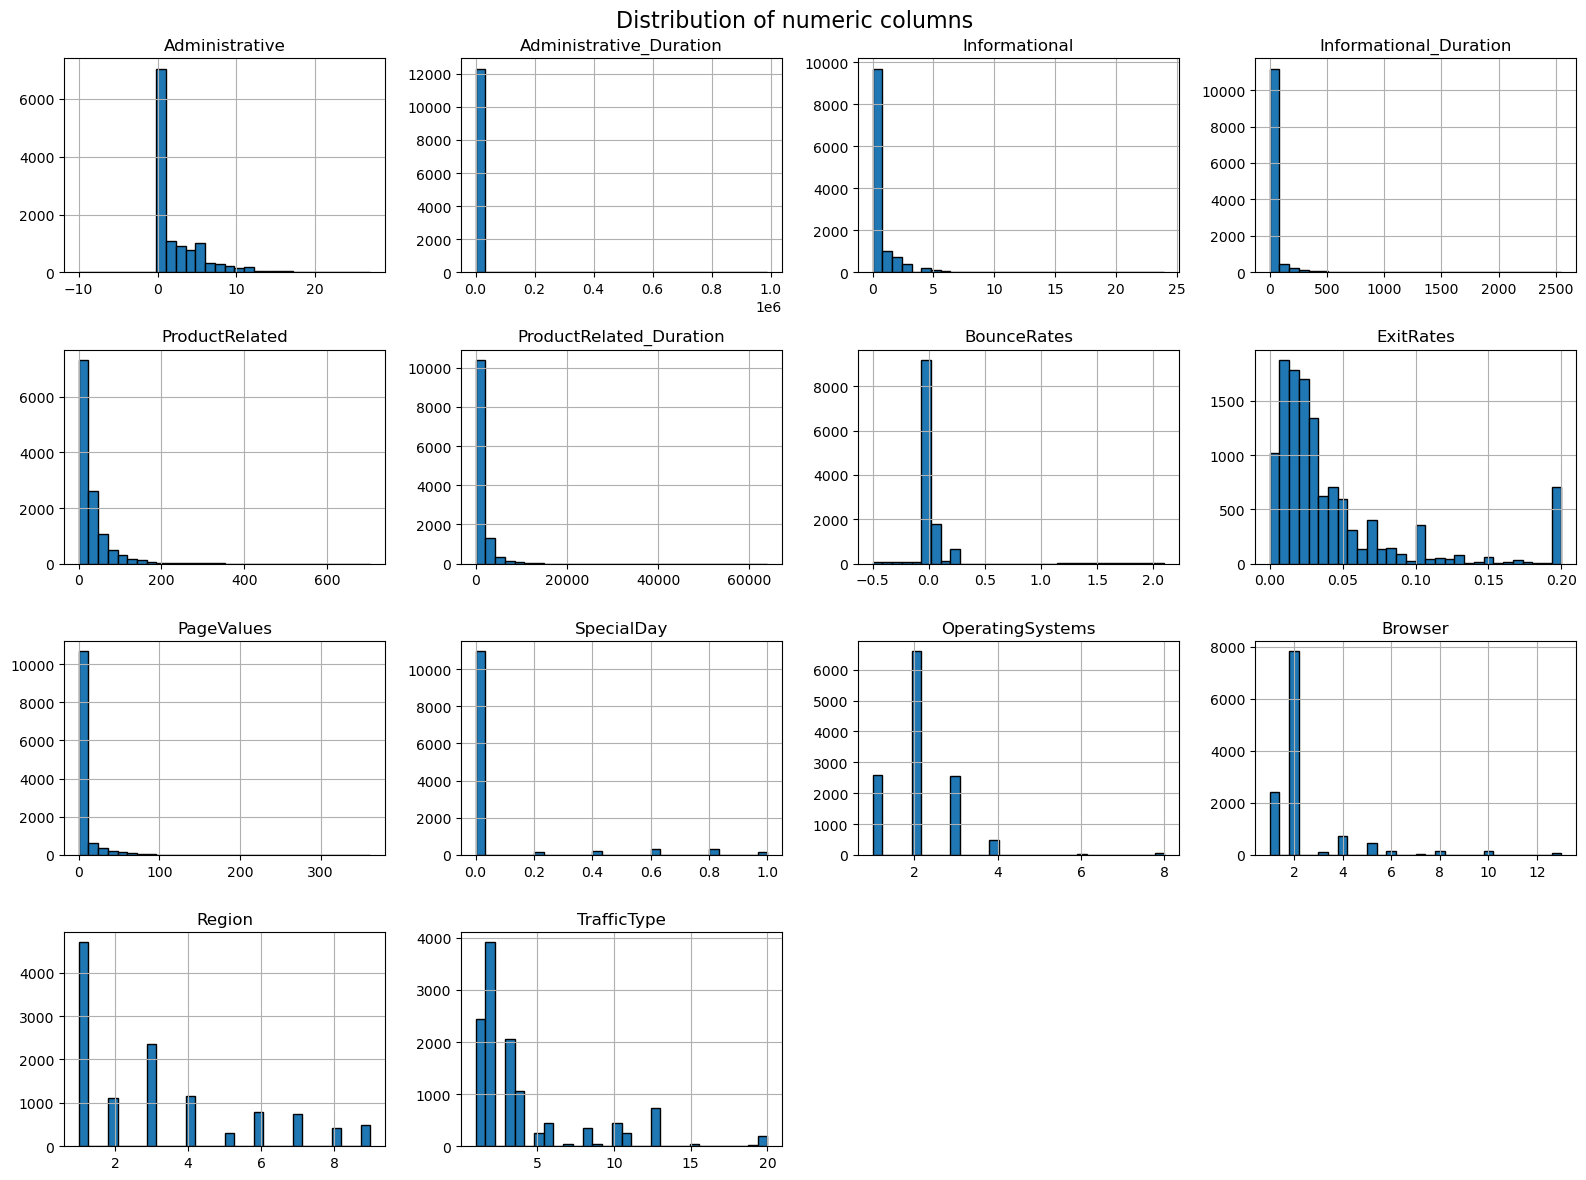

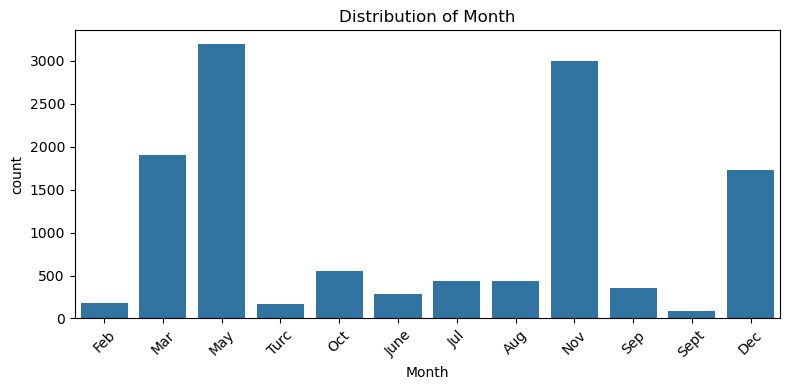

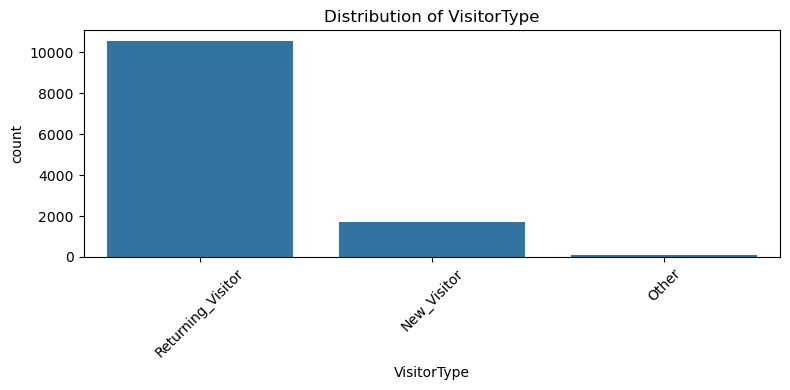

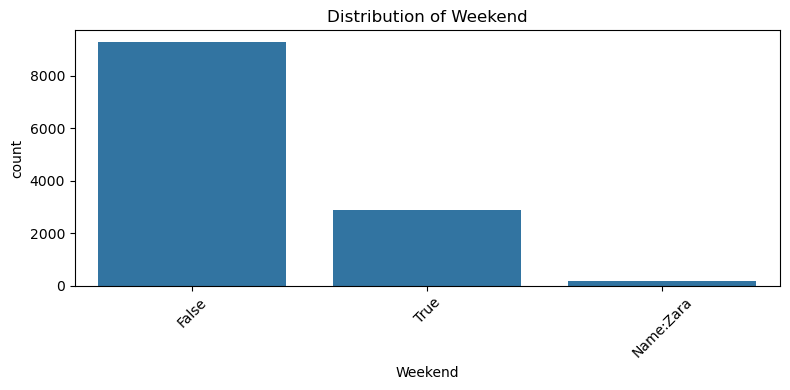

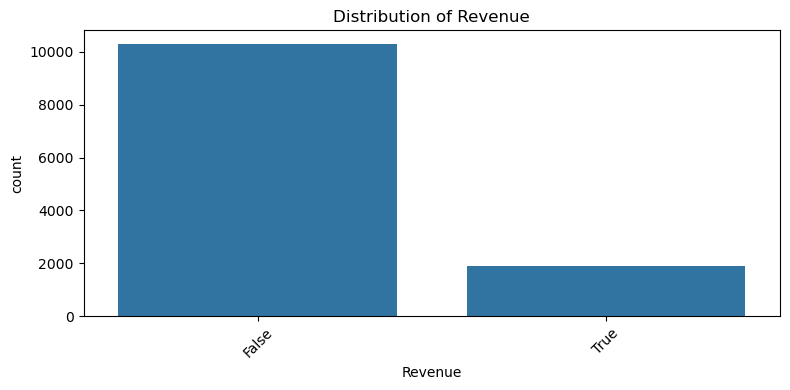

In [544]:
numerical_cols = df.select_dtypes(include=["float64", "int64"]).columns
df[numerical_cols].hist(figsize=(16, 12), bins=30, edgecolor='black')
plt.suptitle("Distribution of numeric columns", fontsize=16)
plt.tight_layout()
plt.show()

categorical_cols = df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [545]:
print(df["SpecialDay"].value_counts())
print(df["SpecialDay"].isnull().sum())

print(df["Browser"].value_counts())
print(df["Browser"].isnull().sum())

print(df["Region"].value_counts())
print(df["Region"].isnull().sum())

SpecialDay
0.0    10971
0.6      346
0.8      321
0.4      240
0.2      177
1.0      152
Name: count, dtype: int64
123
Browser
2.0     7835
1.0     2424
4.0      725
5.0      465
6.0      171
10.0     160
8.0      135
3.0      104
13.0      61
7.0       49
12.0      10
11.0       6
9.0        1
Name: count, dtype: int64
184
Region
1.0    4695
3.0    2345
4.0    1157
2.0    1113
6.0     787
7.0     743
9.0     501
8.0     427
5.0     316
Name: count, dtype: int64
246


---

<h3>Data Preprocessing</h3>

In [546]:
print(f"Before change: {df['Weekend'].value_counts()}") # När jag kollar kaggle dokumentation verkar den vara 2868(True) och 9462(False) så jag grundar att lägga över alla Name:Zara som False då det är de värden som ligger fel
df.loc[df["Weekend"] == "Name:Zara", "Weekend"] = "False"
print(f"After change: {df['Weekend'].value_counts()}")


Before change: Weekend
False        9273
True         2868
Name:Zara     189
Name: count, dtype: int64
After change: Weekend
False    9462
True     2868
Name: count, dtype: int64


In [547]:
df = df.dropna(subset=["Revenue"])    #Ta bort rader med NAN i min target kolumn, eftersom antalet är litet och jag inte vill introducera bias i data
df = pd.get_dummies(df, columns=["Revenue"], dtype=int, drop_first=True)
df = pd.get_dummies(df, columns=["Weekend"], dtype=int, drop_first=True)
df = pd.get_dummies(df, columns=["VisitorType"], dtype=int, drop_first=True)
df.rename(columns={"VisitorType_Returning_Visitor": "Returning_Visitor"}, inplace=True)
df.rename(columns={"Weekend_True": "Weekend"}, inplace=True)
df.rename(columns={"Revenue_True": "Revenue"}, inplace=True)


print(df.info())
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 12183 entries, 0 to 12329
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12183 non-null  int64  
 1   Administrative_Duration  12183 non-null  float64
 2   Informational            12183 non-null  int64  
 3   Informational_Duration   12183 non-null  float64
 4   ProductRelated           12183 non-null  int64  
 5   ProductRelated_Duration  12183 non-null  float64
 6   BounceRates              12183 non-null  float64
 7   ExitRates                12183 non-null  float64
 8   PageValues               12183 non-null  float64
 9   SpecialDay               12061 non-null  float64
 10  Month                    12183 non-null  object 
 11  OperatingSystems         12183 non-null  int64  
 12  Browser                  12001 non-null  float64
 13  Region                   11939 non-null  float64
 14  TrafficType              12

Administrative               0
Administrative_Duration      0
Informational                0
Informational_Duration       0
ProductRelated               0
ProductRelated_Duration      0
BounceRates                  0
ExitRates                    0
PageValues                   0
SpecialDay                 122
Month                        0
OperatingSystems             0
Browser                    182
Region                     244
TrafficType                  0
Revenue                      0
Weekend                      0
VisitorType_Other            0
Returning_Visitor            0
dtype: int64

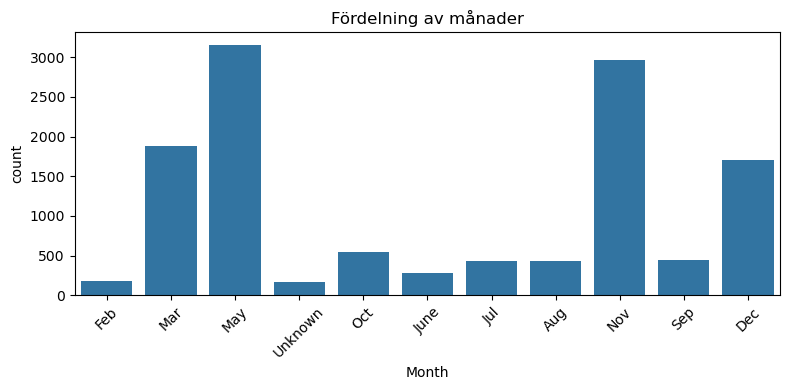

<class 'pandas.core.frame.DataFrame'>
Index: 12183 entries, 0 to 12329
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12183 non-null  int64  
 1   Administrative_Duration  12183 non-null  float64
 2   Informational            12183 non-null  int64  
 3   Informational_Duration   12183 non-null  float64
 4   ProductRelated           12183 non-null  int64  
 5   ProductRelated_Duration  12183 non-null  float64
 6   BounceRates              12183 non-null  float64
 7   ExitRates                12183 non-null  float64
 8   PageValues               12183 non-null  float64
 9   SpecialDay               12061 non-null  float64
 10  OperatingSystems         12183 non-null  int64  
 11  Browser                  12001 non-null  float64
 12  Region                   11939 non-null  float64
 13  TrafficType              12183 non-null  int64  
 14  Revenue                  12

In [548]:
df["Month"] = df["Month"].replace("Sept", "Sep") #Det troliga att någon har skrivit sept istället för sep så jag har slagit ihop de till samma månad
df["Month"] = df["Month"].replace("Turc", "Unknown") #Jag kan inte gissa vilken månad "Turc" är så den får vara "Unknown"

plt.figure(figsize=(8, 4))
sns.countplot(x=df["Month"], data=df)
plt.title("Fördelning av månader")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
df = pd.get_dummies(df, columns=["Month"], dtype=int, drop_first=True)
df.info()

In [549]:
df["Administrative"] = df["Administrative"].abs() #Jag märkte att det fanns negativa värden som jag ändrar till poitiva då de inte bör vara negativa
print(df["Administrative"].unique())

[ 0  1  2  4 12  3 10  6  8  5  7 16 13 11  9 18 14 17 19 15 24 22 21 20
 23 27 26]


In [550]:
df = df[[col for col in df.columns if col != "Revenue"] + ["Revenue"]] # Lägger min target som sista kolumn


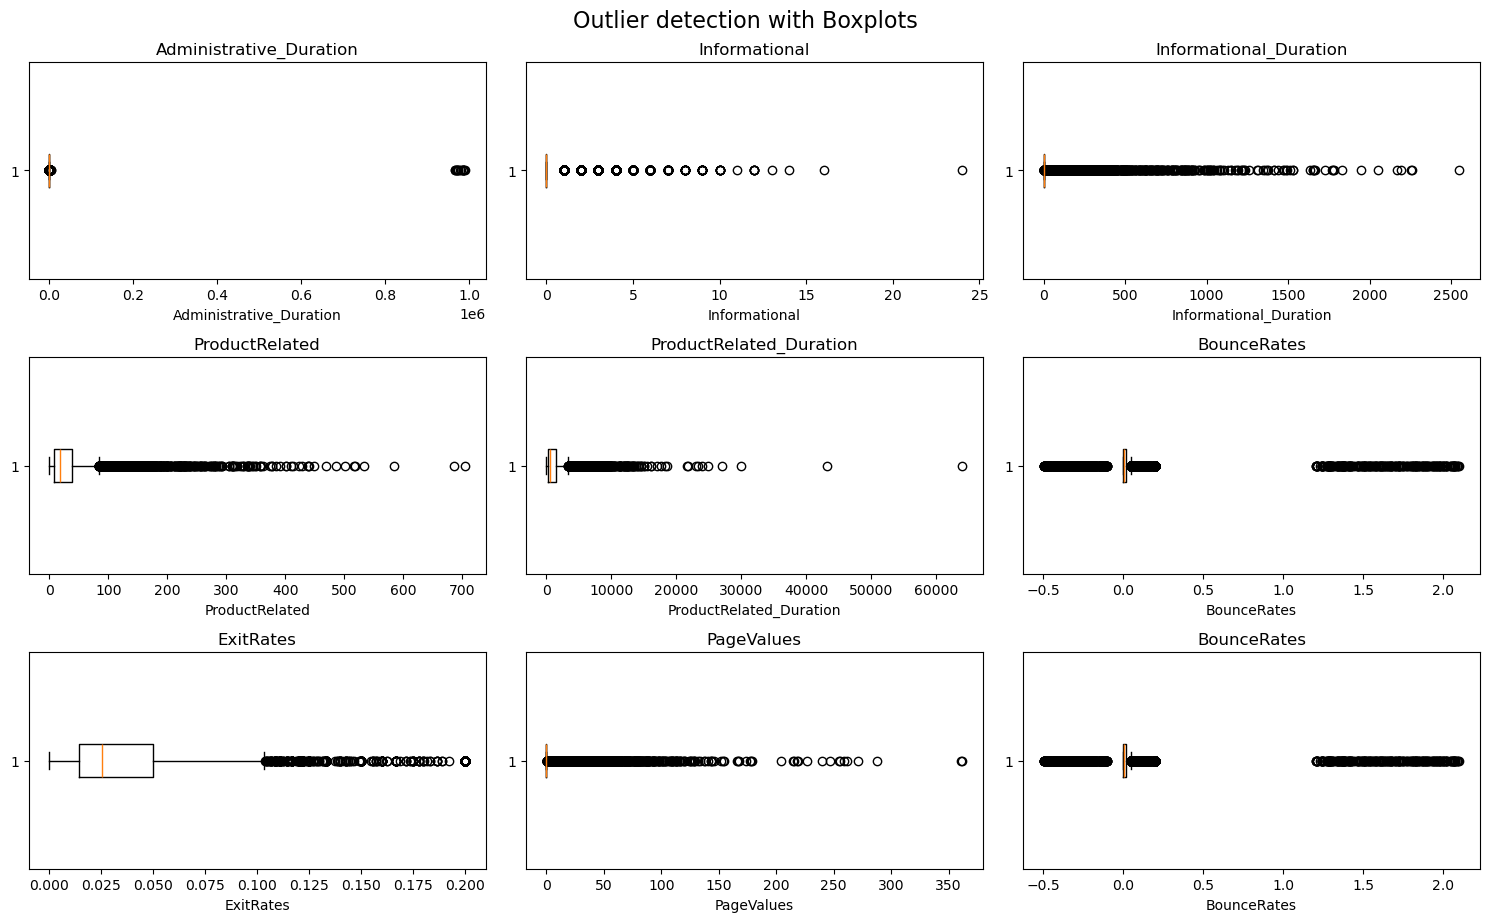

In [551]:
#Försöka visulaiser outliers
columns = [
    "Administrative_Duration", "Informational", "Informational_Duration", "ProductRelated", "ProductRelated_Duration",
    "BounceRates", "ExitRates", "PageValues", "BounceRates"
]
n_cols = 3
n_rows = (len(columns) + n_cols - 1) // n_cols 

plt.figure(figsize=(n_cols * 5, n_rows * 3))

for i, col in enumerate(columns):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.boxplot(df[col], vert=False)
    plt.title(col)
    plt.xlabel(col)

plt.tight_layout()
plt.suptitle("Outlier detection with Boxplots", fontsize=16, y=1.02)
plt.show()

Jag måste hantera outliers på något sätt, läste om "Pipeline" och "RobustScaler" som jag tänkte testa.

In [552]:
df[df["BounceRates"] < 0]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,VisitorType_Other,Returning_Visitor,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Month_Unknown,Revenue
15,2,53.00,0,0.0,23,1668.285119,-0.395564,0.016313,0.000000,0.0,1,1.0,9.0,3,0,0,1,0,1,0,0,0,0,0,0,0,0,0
24,0,0.00,0,0.0,1,0.000000,-0.383570,0.200000,0.000000,0.0,2,2.0,NaN,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0
42,0,0.00,0,0.0,15,310.166667,-0.409885,0.006667,0.000000,0.0,1,1.0,4.0,4,0,0,1,0,1,0,0,0,0,0,0,0,0,0
45,0,0.00,0,0.0,22,622.250000,-0.458046,0.006061,0.000000,0.2,2,5.0,1.0,4,0,0,1,0,1,0,0,0,0,0,0,0,0,0
67,0,0.00,0,0.0,1,0.000000,-0.141745,0.200000,0.000000,0.6,2,2.0,5.0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12032,1,58.50,0,0.0,23,1033.000000,-0.166448,0.037500,0.000000,0.0,2,2.0,3.0,2,0,0,1,1,0,0,0,0,0,0,0,0,0,0
12212,0,0.00,0,0.0,13,223.416667,-0.449637,0.023077,0.000000,0.0,2,4.0,1.0,2,0,0,1,1,0,0,0,0,0,0,0,0,0,0
12263,2,23.00,0,0.0,12,284.500000,-0.397288,0.014286,0.000000,0.0,2,2.0,3.0,2,0,0,1,1,0,0,0,0,0,0,0,0,0,0
12266,2,223.75,3,165.0,51,2159.004167,-0.259273,0.037347,10.229937,0.0,1,1.0,1.0,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [553]:
df["BounceRates"] = df["BounceRates"].abs() #Jag märkte att det fanns negativa värden i denna kolumn också som jag ändrar till poitiva då de inte bör vara negativa
print(df["BounceRates"].unique())

[0.2        0.         0.05       ... 1.61050368 0.41551258 0.01114899]


---

<h3>Train/test-split & Model selection</h3>

In [554]:
X = df.drop("Revenue", axis=1)
y = df["Revenue"]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


=== Training RandomForest ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters for RandomForest:
{'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 500}

Evaluating based on validation data:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      2075
           1       0.56      0.77      0.65       362

    accuracy                           0.88      2437
   macro avg       0.76      0.83      0.79      2437
weighted avg       0.90      0.88      0.88      2437

Accuracy: 0.8765
Precision: 0.5616
Recall: 0.7680
F1 Score: 0.6488



=== Training DecisionTree ===
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best parameters for DecisionTree:
{'model__max_depth': 5, 'model__min_samples_split': 2}

Evaluating based on validation data:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      2075
           1       0.51    

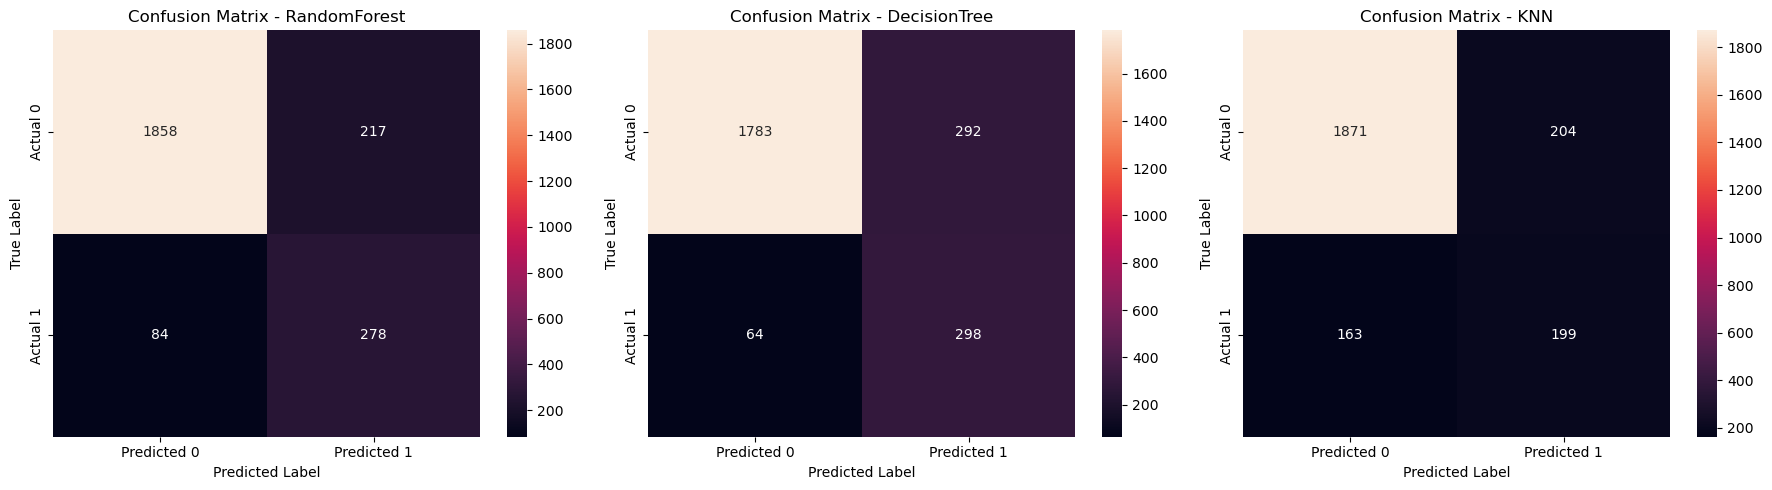

In [566]:

models = {
    "RandomForest": {
        "pipeline": Pipeline([
            ("imputer", KNNImputer(n_neighbors=5)),
            ("smote", SMOTE(sampling_strategy=0.4, random_state=42)),
            ("scaler", RobustScaler()),
            ("model", RandomForestClassifier(class_weight="balanced", random_state=42))
        ]),
        "params": {
            "model__n_estimators": [300, 500],
            "model__max_depth": [5, 10, 20],
            "model__min_samples_split": [2, 5]
        }
    },
    "DecisionTree": {
        "pipeline": Pipeline([
            ("imputer", KNNImputer(n_neighbors=5)),
            ("smote", SMOTE(sampling_strategy=0.4, random_state=42)),
            ("scaler", RobustScaler()),
            ("model", DecisionTreeClassifier(class_weight="balanced", random_state=42))
        ]),
        "params": {
            "model__max_depth": [2, 5],
            "model__min_samples_split": [2, 5]
        }
    },
    "KNN": {
        "pipeline": Pipeline([
            ("imputer", KNNImputer(n_neighbors=5)),
            ("smote", SMOTE(sampling_strategy=0.4, random_state=42)),
            ("scaler", RobustScaler()),
            ("model", KNeighborsClassifier())
        ]),
        "params": {
            "model__n_neighbors": [7, 10, 20],
            "model__weights": ["uniform", "distance"]
        }
    }
}


def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    print(classification_report(y_val, y_pred))
    print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
    print(f"Precision: {precision_score(y_val, y_pred):.4f}")  
    print(f"Recall: {recall_score(y_val, y_pred):.4f}")        
    print(f"F1 Score: {f1_score(y_val, y_pred):.4f}")
    print("\n" + "="*50 + "\n")

best_models = {}

for model_name, config in models.items():
    print(f"\n=== Training {model_name} ===")
    
    grid = GridSearchCV(
        config["pipeline"],
        config["params"],
        cv=5,
        scoring="f1",
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    best_models[model_name] = grid.best_estimator_
    
    print(f"\nBest parameters for {model_name}:")
    print(grid.best_params_)
    print("\nEvaluating based on validation data:")
    evaluate_model(grid.best_estimator_, X_val, y_val)

def plot_confusion_matrix(y_true, y_pred, model_name, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", 
                xticklabels=["Predicted 0", "Predicted 1"], 
                yticklabels=["Actual 0", "Actual 1"], ax=ax)
    ax.set_title(f"Confusion Matrix - {model_name}")
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
model_names = ["RandomForest", "DecisionTree", "KNN"]

for ax, model_name in zip(axes, model_names):
    if model_name in best_models:
        y_pred = best_models[model_name].predict(X_val)
        plot_confusion_matrix(y_val, y_pred, model_name, ax)

plt.tight_layout()
plt.show()

Inte det bästa resultat så jag ska prova med andra modeller som är mer anpassade för obalanserad data och hoppas att jag får bättre score.


=== Training BalancedRandomForest ===
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best parameters for BalancedRandomForest:
{'model__max_depth': 50, 'model__min_samples_split': 2, 'model__n_estimators': 300}

Evaluating based on validation data:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      2075
           1       0.58      0.75      0.65       362

    accuracy                           0.88      2437
   macro avg       0.77      0.83      0.79      2437
weighted avg       0.90      0.88      0.89      2437

Accuracy: 0.8810
Precision: 0.5759
Recall: 0.7541
F1 Score: 0.6531



=== Training AdaBoost ===
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best parameters for AdaBoost:
{'model__learning_rate': 0.5, 'model__n_estimators': 20}

Evaluating based on validation data:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2075
           1     

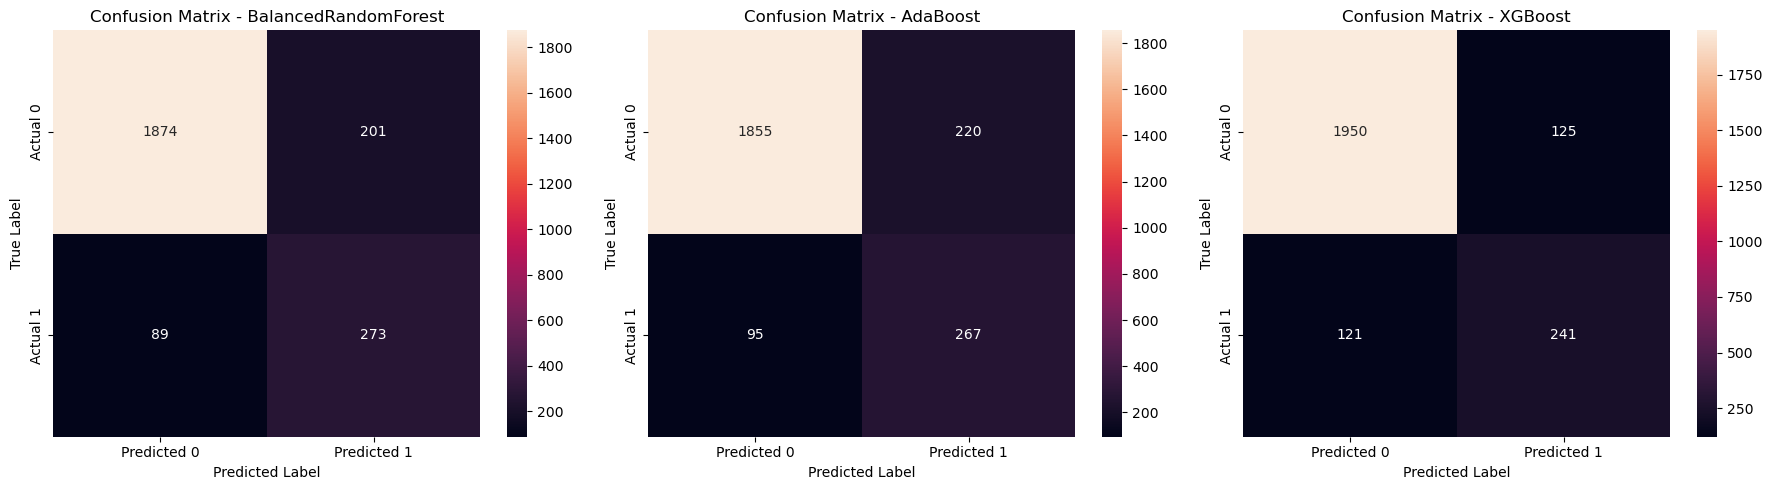

In [567]:

models = {
    "BalancedRandomForest": {
        "pipeline": Pipeline([
            ("imputer", KNNImputer(n_neighbors=5)),
            ("smote", SMOTE(sampling_strategy=0.4, random_state=42)),
            ("scaler", RobustScaler()),
            ("model", BalancedRandomForestClassifier(class_weight = {0: 1, 1: 3} , random_state=42))
        ]),
        "params": {
            "model__n_estimators": [300, 350],
            "model__max_depth": [15, 20, 50],
            "model__min_samples_split": [2, 5, 10]
        }
    },
    "AdaBoost": {
        "pipeline": Pipeline([
            ("imputer", KNNImputer(n_neighbors=5)),
            ("smote", SMOTE(sampling_strategy=0.4, random_state=42)),
            ("scaler", RobustScaler()),
            ("model", AdaBoostClassifier(random_state=42))
        ]),
        "params": {
            "model__n_estimators": [10, 20, 50],
            "model__learning_rate": [0.3, 0.5, 1.0]
        }
    },
     "XGBoost": {
        "pipeline": Pipeline([
            ("imputer", KNNImputer(n_neighbors=5)),
            ("smote", SMOTE(sampling_strategy=0.4, random_state=42)),
            ("scaler", RobustScaler()),
            ("model", XGBClassifier(eval_metric="logloss", random_state=42))
        ]),
        "params": {
            "model__n_estimators": [200, 300, 350],
            "model__max_depth": [3, 5, 7],
            "model__learning_rate": [0.05, 0.1, 0.2]
        }
    }
}

for model_name, config in models.items():
    print(f"\n=== Training {model_name} ===")
    
    grid = GridSearchCV(
        config["pipeline"],
        config["params"],
        cv=5,
        scoring="f1",
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    best_models[model_name] = grid.best_estimator_
    
    print(f"\nBest parameters for {model_name}:")
    print(grid.best_params_)
    print("\nEvaluating based on validation data:")
    evaluate_model(grid.best_estimator_, X_val, y_val)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
model_names = ["BalancedRandomForest", "AdaBoost", "XGBoost"]

for ax, model_name in zip(axes, model_names):
    if model_name in best_models:
        y_pred = best_models[model_name].predict(X_val)
        plot_confusion_matrix(y_val, y_pred, model_name, ax)

plt.tight_layout()
plt.show()


ok, det är inte en jätte stor skillnad. Tänkte prova en sista grej som jag läste på "Geeks for Geeks", BalancedBaggingClassifier istället för SMOTE.


=== Training RandomForest ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters for RandomForest:
{'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 500}

Evaluating based on validation data:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2075
           1       0.59      0.75      0.66       362

    accuracy                           0.89      2437
   macro avg       0.77      0.83      0.79      2437
weighted avg       0.90      0.89      0.89      2437

Accuracy: 0.8851
Precision: 0.5895
Recall: 0.7459
F1 Score: 0.6585



=== Training DecisionTree ===
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best parameters for DecisionTree:
{'model__max_depth': 2, 'model__min_samples_split': 2}

Evaluating based on validation data:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      2075
           1       0.52    

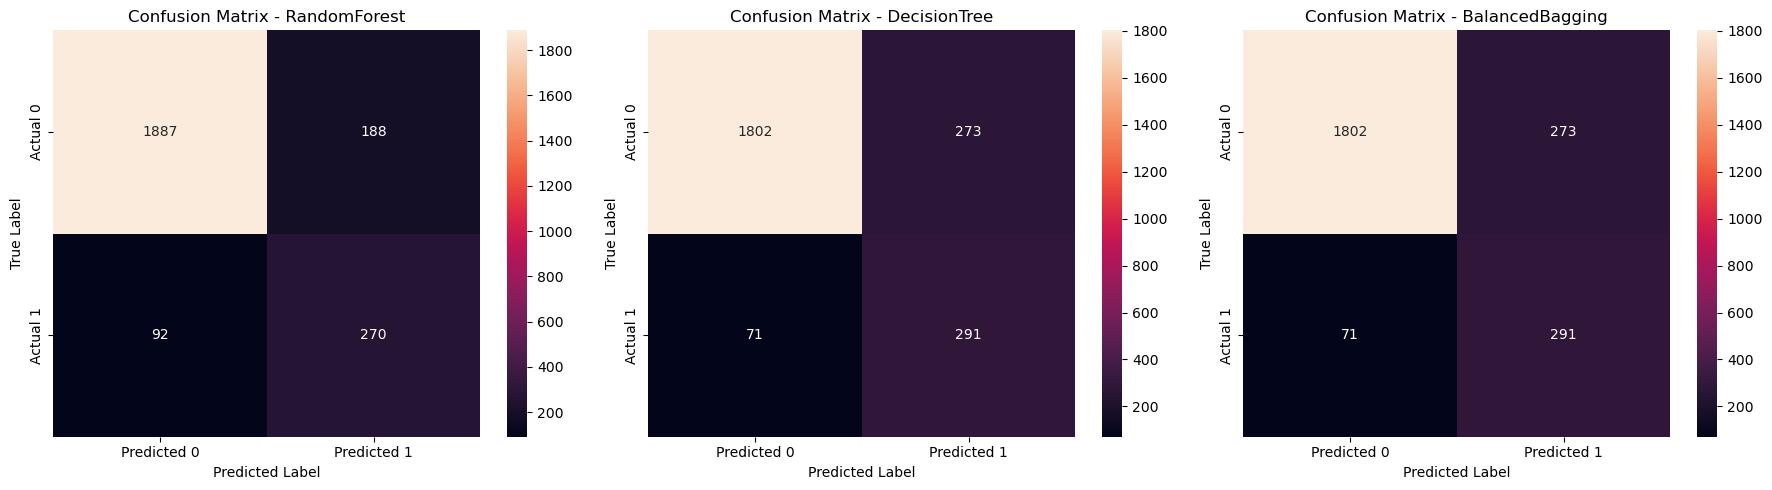

In [569]:
models = {
    "RandomForest": {
        "pipeline": Pipeline([
            ("imputer", KNNImputer(n_neighbors=5)),
            ("scaler", RobustScaler()),
            ("model", RandomForestClassifier(class_weight = {0: 1, 1: 3} , random_state=42))
        ]),
        "params": {
            "model__n_estimators": [300, 500],
            "model__max_depth": [5, 10, 20],
            "model__min_samples_split": [2, 5]
        }
    },
    "DecisionTree": {
        "pipeline": Pipeline([
            ("imputer", KNNImputer(n_neighbors=5)),
            ("scaler", RobustScaler()),
            ("model", DecisionTreeClassifier(class_weight = {0: 1, 1: 3} , random_state=42))
        ]),
        "params": {
            "model__max_depth": [2, 5],
            "model__min_samples_split": [2, 5]
        }
    },
    "BalancedBagging": {
        "pipeline": Pipeline([
            ("imputer", KNNImputer(n_neighbors=5)),
            ("scaler", RobustScaler()),
            ("model", BalancedBaggingClassifier(
                estimator=DecisionTreeClassifier(max_depth=2),
                n_estimators=100,
                sampling_strategy="auto",
                replacement=False,
                random_state=42,
                n_jobs=-1
            ))
        ]),
        "params": {
            "model__n_estimators": [50, 100, 150]
        }
    }
}
for model_name, config in models.items():
    print(f"\n=== Training {model_name} ===")
    
    grid = GridSearchCV(
        config["pipeline"],
        config["params"],
        cv=5,
        scoring="f1",
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    best_models[model_name] = grid.best_estimator_
    
    print(f"\nBest parameters for {model_name}:")
    print(grid.best_params_)
    print("\nEvaluating based on validation data:")
    evaluate_model(grid.best_estimator_, X_val, y_val)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
model_names = ["RandomForest", "DecisionTree", "BalancedBagging"]

for ax, model_name in zip(axes, model_names):
    if model_name in best_models:
        y_pred = best_models[model_name].predict(X_val)
        plot_confusion_matrix(y_val, y_pred, model_name, ax)

plt.tight_layout()
plt.show()

Jag kommer fram till att XGBoost är bästa modellen för detta dataset pga att den har högsta F1-score som är en balans mellan Precision och Recall samt har hög Accuracy. Med tanke på att det är en obalanserad dataset då är F1 väldig viktig för minoritet klassen i mitt dataset. 

In [575]:
#Anväder nu XGBoost för att träna på hela datasetet
neg, pos = np.bincount(y_train_val)
scale_pos_weight = neg / pos

final_xgb_pipeline = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("smote", SMOTE(sampling_strategy=0.6, random_state=42)),
    ("scaler", RobustScaler()),
    ("model", XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        scale_pos_weight=scale_pos_weight,
        eval_metric="logloss",
        random_state=42
    ))
])

final_xgb_pipeline.fit(X_train_val, y_train_val)

Pipeline(steps=[('imputer', KNNImputer()),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.6)),
                ('scaler', RobustScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_...s=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

=== Final Evaluation on Test Data ===
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      2058
           1       0.56      0.85      0.68       379

    accuracy                           0.87      2437
   macro avg       0.77      0.87      0.80      2437
weighted avg       0.91      0.87      0.88      2437

Accuracy: 0.8740
Precision: 0.5625
Recall: 0.8549
F1 Score: 0.6785




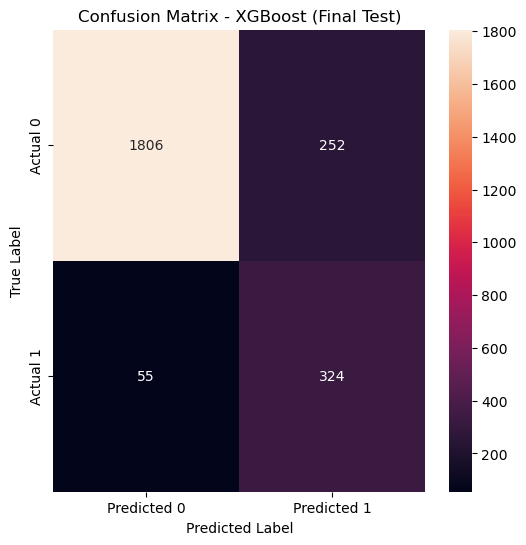

In [576]:
print("=== Final Evaluation on Test Data ===")
evaluate_model(final_xgb_pipeline, X_test, y_test)

fig, ax = plt.subplots(figsize=(6, 6))
y_pred_test = final_xgb_pipeline.predict(X_test)
plot_confusion_matrix(y_test, y_pred_test, "XGBoost (Final Test)", ax)
plt.show()

---

<h2>Presentation för ledningen</h2>

<h4>Projektbeskrivning</h4>
<p>I takt med att den digitala konkurrensen hårdnat vill Kokobananas förbättra sin digital användarupplevelse. Trots att det är många besökare på hemsidan verkar de flesta inte konvertera, vilket innebär utebliven försäljning. För att kunna ebjuda rätt innehåll i realtid är det viktigt att förstå vilka besökare som sannolikt kommer att göra ett köp eller inte.</p>
<p>Mitt uppdrag är att utveckla en AI-modell, som i realtid förutsäger om en kund kommer att göra ett köp eller inte. Syftet är att ge företaget möjlighet att agera direkt t.ex. med erbjudande, rabatter eller personlig hjälp.</p>
<h4>Bekrivning av arbete</h4>
<p>Jag har använt historisk data från tidigare kundsessioner för att träna "XGBoost" en AI-modell som ska kunna analysera om kunden kommer att köpa något eller inte. Hur modellen funkar är att den lär sig se mönster då den tränas på tidigare kundbeteenden för att veta vad som kännetecknar någon som kommer att köpa.</p>
<p>Datat från de tidigare kundsessionerna var inte optimala dvs att det saknades en del värden, fel skrivningar på vissa värden och att vissa värden var underrepresenterade bland annat. För att kunna få en bra modell måste datat rensas och det får inte finnas tomma värden.</p>
<p>För att förbättra modellen prestanda genomförde:</p>
<li>Omskrivning av felaktiga värden som tex månaden sep och sept slogs ihop, månaden turc blev "Unknown"</li>
<li>Där värden saknas fylls det i värden baserat på liknande kunders beteende med hjälp av "KNNImputer"</li>
<li>Datat är överrepresenterat i kunder som inte köper något, vilket gör det svårt för modellen att lära sig känna igen de som köper. Därför har jag skapat konstgjorda exempel på köpande kunder för att kunna ge modellen fler exempel att lära sig av. Alltså skapa balans i datat men hälp av "SMOTE"</li>
<li>Viss data varierar extremt, tex på hur länge en kund är på en viss sida. Så jag har omvandlat siffrorna så de är mer jämförbara för att modellen inte ska luras av extremvärden.("RobustScaler")</li>
<li>Jag har tagit hjälp av "Pipeline" som kopplar ihop alla dessa steg (förutom den första) i rätt ordning, och ser till att allt körs automatiskt varje gång en ny kundsession analyseras.</li>
<li>Jag testade olika modellinställningar med hjälp av "Gridsearch" för att hitta bästa komination. </li>
<li>Jag testade och jämförde olika modeller och valde den som kan förutspå ett köp med fokus på träffsäkerhet och noggrannhet.</li> 
<h4>Resultat</h4>
<p>Modellen har utvärderats på testdata (data som den inte har tidigare sett), reultatet:</p>
<li>Modellen har en träffsäkerhet på 87.4% på det totala testdatat, kunder som köper eller inte köper (Accuracy)</li>
<li>Modellen identiferar rätt på kunder som faktiskt köper något ca 85.5% (Recall)</li>
<li>Av alla kunder som modellen tror ska köpa något så är det ca 56,3% som faktiskt köper något (Precision)</li>
<li>Balansen mellan Precision och Recall är ca 67.9% (F1-score)</li>
<p>Nedan kan ni se Confusin Matrix som visar fördelningen på hur modellen har förutspått köp eller inte köp.</p>

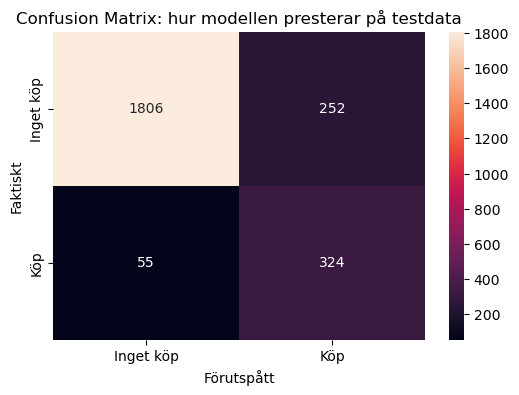

In [590]:
y_pred = final_xgb_pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Inget köp", "Köp"], yticklabels=["Inget köp", "Köp"])
plt.xlabel("Förutspått")
plt.ylabel("Faktiskt")
plt.title("Confusion Matrix: hur modellen presterar på testdata")
plt.show()


<p>Från denna matris kan man se hur modellen har presterat på osedd data.</p>
<li>Av 2058 st faktiska "inget köp" har den identiferat korrekt 1806 st, haft fel på 252 st.</li>
<li>Av 379 st faktiska "köp" har den identiferat korrekt 324 st, haft fel på 55 st.</li>

<h5>Viktiga faktorer som påverkar modellen</h5>
<p>Nedan har jag tagit fram en lista på de 10 "feature importance", alltså de variabler eller kolumner, som påverkar vår modell mest:</p>

In [596]:
xgb_model = final_xgb_pipeline.named_steps["model"]
feature_names = X_train_val.columns

feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": xgb_model.feature_importances_
})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(10)
feature_importance_df

,Feature,Importance
8,PageValues,0.402517
23,Month_Nov,0.134405
22,Month_May,0.052529
21,Month_Mar,0.042310
16,Returning_Visitor,0.042131
14,Weekend,0.037796
24,Month_Oct,0.028053
10,OperatingSystems,0.024424
5,ProductRelated_Duration,0.021335
25,Month_Sep,0.018513


<h4>Vad detta innebär för KokoBananas</h4>
<p>Modellen ger en bra möjlighet för företaget i realtid att kunna snabbt identifera kunder som mest sannolikt betäller produkter. Företaget kan då anpassa innehåll och erbjudande för dessa besökare, och öka konverteringen för övriga besökare.</p>
<p>Jag har även testat hur lång tid min modell tar att förutse om en pågående kundsession kommer att leda till köp. Av 100 sessioner så är den genomsnittliga tiden ca 1.7 millisekunder per kund. Detta innebär att modellen är tillräckligt snabb för att köras i realtid, alltså under tiden som kunden är aktiv. Det ger en bra möjlighet för företaget att anpassa innehåll och kampanjer baserat på konverteringsbenägenhet. Se resultat nedan:</p>

In [605]:
sample = X_test.iloc[0:1]
times = []

for _ in range(100):
    start = time.time()
    _ = final_xgb_pipeline.predict(sample)
    end = time.time()
    times.append(end - start)

mean_ms = np.mean(times) * 1000
print(f"Genomsnittlig inference-tid: {mean_ms:.2f} ms över 100 körningar")

Genomsnittlig inference-tid: 1.64 ms över 100 körningar


<h4>Förbättringsförslag och framtida utveckling</h4>
<p>Trots att modellen presterar bra och snabbt nog för att användas i realtid finns det några områden där förbättringar kan göras:</p>
<li><b>Precision för köpande kunder:</b> Även om modellen är bra på att hitta de som faktiskt kommer att köpa (hög Recall), är precisionen lägre. Det innebär att modellen ibland tror att en kund kommer att köpa – men det visar sig inte stämma. För att förbättra detta skulle man kunna: 
<ul><li>Samla in mer data om köpande kunder, för att ge modellen fler relevanta exempel.</li> 
<li>Förfina variablerna (feature engineering) och testa nya kombinationer av data som bättre speglar köpintention.</li> 
<li>Prova andra algoritmer eller flera modeller som samarbetar för bättre precision.</li> </ul> </li>
<li><b>Utökad förståelse för kundbeteenden:</b> Genom att analysera vilka mönster som oftast leder till köp – t.ex. sidor som besöks, tid på dygnet – kan KokoBananas använda dessa insikter för att förbättra både hemsidan och marknadsföringsstrategin.</li> 
<li>Kanske behövs det att rådfråga en domänexpert som kan tala om vilka faktorer man ska lägga mer vikt på.</li> 
<li>Nästa steg kan vara att integrera modellen direkt i KokoBananas webbplattform. På så sätt kan modellen aktivt påverka layout, erbjudanden och chattfunktion beroende på kundens beteende i stunden.</li> 
<p>Sammanfattningsvis är den utvecklade modellen ett starkt beslutstöd som kan hjälpa KokoBananas att agera proaktivt och kundfokuserat. Med fortsatt utveckling och förfining finns goda möjligheter att ytterligare öka konverteringen och förbättra användarupplevelsen.</p>

<h4>Slutsats</h4>
<p>Modellen som jag har utvecklat för KokoBananas visar tydligt att AI kan vara ett kraftfullt verktyg för att förstå kundbeteenden i realtid. Med hög träffsäkerhet (87,4 %) och mycket snabb beräkningstid (ca 1,7 ms per kundsession) kan modellen utan problem användas direkt på hemsidan. Det innebär att företaget får möjlighet att anpassa innehåll och erbjudanden i samma stund som kunden är aktiv, vilket skapar helt nya möjligheter att påverka köpbeslut.

Att modellen lyckas identifiera en stor andel av de kunder som faktiskt genomför köp (Recall: 85,5 %) gör att KokoBananas kan agera proaktivt – exempelvis genom att visa kampanjer, sätta in chatt eller skräddarsy produktrekommendationer. Samtidigt finns förbättringspotential i att öka precisionen, alltså att modellen blir ännu bättre på att gissa rätt på vilka som verkligen kommer att köpa.

Slutligen visar även analysen av vilka faktorer som påverkar modellen mest (feature importance) att det finns tydliga mönster i användarbeteenden som leder till köp. Dessa insikter kan ligga till grund för förbättringar i webbdesign, kampanjplanering och kundstrategi – och därmed stärka KokoBananas konkurrenskraft ytterligare.